# TensorFlow で単回帰

## ~ 梅田のラーメン屋 データ編 ~


### Note
    - `data` ディレクトリに, `ramen_data.csv` を保存しておいてください。
  

### 必要なモジュールを読み込む

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pandas import Series, DataFrame
import pandas as pd
import tensorflow as tf

### ラーメン屋データを読み込む

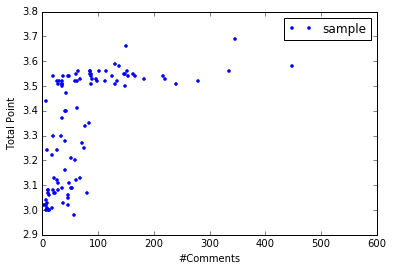

In [2]:
df = pd.read_table("data/ramen_data.csv", delimiter=",", index_col=0)


plt.plot(df.comment.values, df.point_gokei.values, ".", label="sample")
plt.xlabel("#Comments")
plt.ylabel("Total Point")
plt.legend()
plt.show()

# 欠損値を含む行を削除
df = df[["comment", "point_gokei"]].dropna()

comment = df.comment.values / 100. # 学習が効率よく進むよう、pointとデータの幅を近づける (TIPS)
point = df.point_gokei.values

## TensorFlow で単回帰する
### 学習したいモデルを記述する
  - 今回用いるモデル:
          合計ポイント(y) = 係数(a) * コメント数(x) + 切片(b)
  - ※このモデルを複雑にすれば, 予測精度を向上できる(かも)

In [3]:
# 入力変数と出力変数のプレースホルダを生成
x = tf.placeholder(tf.float32, shape=(None, ), name="INPUT")
y_ = tf.placeholder(tf.float32, shape=(None, ), name="OUTPUT")

# モデルパラメータ
a = tf.Variable(0., name="a")
b = tf.Variable(0., name="b")

# モデル式
with tf.name_scope("linear"):
    y = x * a + b

### 学習やテストに必要な関数を定義する

In [4]:
# 訓練手続き
with tf.name_scope("Train"):
    # コスト関数
    with tf.name_scope("MSE"):
        cost = tf.reduce_mean(tf.square(y_ - y))
        c_summ = tf.scalar_summary("cost(mse)", cost) # for Summary
    # 最急降下法
    with tf.name_scope("Optimizer"):
        train_step = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

# 正答率
with tf.name_scope("Test"):
    with tf.name_scope("RMSE"):
        rmse = tf.sqrt(tf.reduce_mean(tf.square(y_ - y)))

### 実際に学習処理を実行する

In [5]:
# セッションを準備
sess = tf.Session()

# 変数の初期化処理
init = tf.initialize_all_variables()
sess.run(init)

# サマリーデータを出力
merged_summ = tf.merge_all_summaries()
writer = tf.train.SummaryWriter("data/ramen_regression", graph_def=sess.graph_def)

for i in range(1000):
    # 最急勾配法でパラメータ更新
    _, summ = sess.run([train_step, merged_summ], feed_dict={x: comment, y_: point})
    writer.add_summary(summ, i)

writer.close()

# 学習結果を出力
est_rmse, est_a, est_b = sess.run([rmse, a, b], feed_dict={x: comment, y_: point})
print "Estimated: a=%.2f, b=%.2f, rmse=%.2f" % (est_a, est_b, est_rmse)

Estimated: a=0.15, b=3.22, rmse=0.18


### 推定された回帰直線を描画する

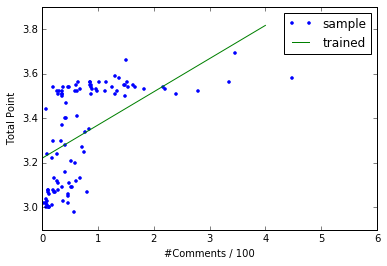

In [6]:
# 回帰直線をプロット
line_x = np.linspace(0., 400., 10) / 100.
line_y = sess.run(y, feed_dict={x: line_x}) # 学習結果を使い, 新しいxに対する予測値を得る

plt.plot(comment, point, ".", label="sample")
plt.plot(line_x, line_y, "-", label="trained")
plt.xlabel("#Comments / 100")
plt.ylabel("Total Point")
plt.legend()
plt.show()

### 後片付け

In [7]:
# セッションを閉じる
sess.close()

### 補足: TensorBoard

- 次の行をシェルで実行すると, 学習の進み具合やネットワーク構造を可視化できるWebUIが立ち上がります。

    $ tensorboard --logdir=(カレントディレクトリの絶対パス)/data/ramen_regression